In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf
import math

# Pre processing

In [2]:
path = '/anomalyvol/data/jet_ver/bb1_ae_input.h5'

In [3]:
chunk_size = 100000
total_size = 1000000 # 1 mil max

def generator(path, chunk_size=10000,total_size=1000000):
    i = 0
    
    while True:
        yield pd.read_hdf(path,start=i*chunk_size, stop=(i+1)*chunk_size)
        
        i+=1
        if (i+1)*chunk_size > total_size:
            i=0

gen = generator(path, chunk_size, total_size)

In [4]:
data = next(gen)

for i in range(total_size // chunk_size - 1):
    data.append(next(gen))

In [5]:
loaded_data = data
# data = loaded_data

In [6]:
data = np.array(data)
data = data[:,:4]  # just keep px, py, pz, e
data.shape

(100000, 4)

In [7]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [8]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [9]:
# get the inverse iqr proportion for each feature used to scale their weights in the loss function
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.01960501 0.01973707 0.22276554 1.        ]


# VAE Model

In [10]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [11]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [13]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [14]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [15]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [16]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [17]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
batch_size = 1000
epochs = 200

In [20]:
x_train.shape

(80000, 4)

In [21]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [22]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 80000 samples, validate on 10000 samples
Epoch 1/200
80000/80000 [==============================] - 1s 14us/step - loss: 0.2149 - val_loss: 0.1073
Epoch 2/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0805 - val_loss: 0.0693
Epoch 3/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0682 - val_loss: 0.0667
Epoch 4/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0667 - val_loss: 0.0662
Epoch 5/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0662 - val_loss: 0.0659
Epoch 6/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0659 - val_loss: 0.0657
Epoch 7/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0657 - val_loss: 0.0656
Epoch 8/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0654 - val_loss: 0.0651
Epoch 9/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0645 - val_loss: 0.0631
Epoc

Epoch 78/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 79/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 80/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 81/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0103
Epoch 82/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0103
Epoch 83/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 84/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 85/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 86/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 87/200
80000/80000 [====================

# Visualization

In [23]:
import matplotlib.pyplot as plt

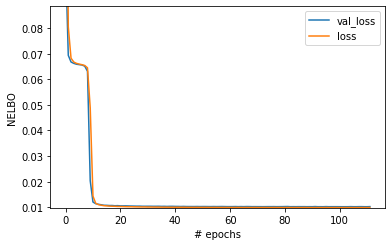

In [24]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [25]:
predictions = vae.predict(x_test)

In [26]:
# mse on test set
p = vae.predict(x_train)
print(mse(p, x_train))

tf.Tensor(0.5000589, shape=(), dtype=float32)


In [27]:
distr = (x_test - predictions) / x_test

In [28]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [29]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [30]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([1.5000e+01, 2.3000e+01, 3.1000e+01, 2.0000e+01, 2.6000e+01,
        2.4000e+01, 2.5000e+01, 2.5000e+01, 2.4000e+01, 4.3000e+01,
        3.0000e+01, 5.3100e+03, 9.0800e+02, 4.4800e+02, 2.8700e+02,
        2.2300e+02, 2.1400e+02, 1.6700e+02, 1.8500e+02, 1.4300e+02,
        2.1700e+02, 2.9800e+02, 6.9700e+02, 1.9220e+03, 2.1834e+04,
        1.5830e+03, 4.2800e+02, 2.5700e+02, 1.7600e+02, 1.3200e+02,
        1.3900e+02, 9.0000e+01, 8.0000e+01, 7.5000e+01, 8.1000e+01,
        5.6000e+01, 5.9000e+01, 5.8000e+01, 6.7000e+01, 5.2000e+01,
        4.9000e+01, 4.9000e+01, 4.8000e+01, 5.3000e+01, 5.1000e+01,
        5.2000e+01, 4.6000e+01, 4.6000e+01, 4.4000e+01]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.1

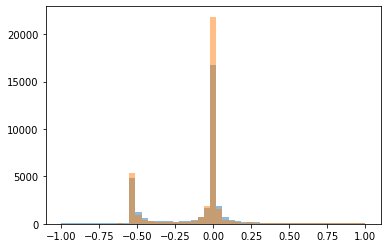

In [31]:
# overall pred vs input
bins = np.linspace(-1, 1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([   80.,    83.,    92.,   110.,   120.,   132.,   139.,   167.,
          173.,   178.,   253.,   228.,   348.,   579., 14427.,  2354.,
         1550.,   531.,   434.,   422.,   594.,  4472.,   949.,   408.,
          317.,   265.,   240.,   209.,   209.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

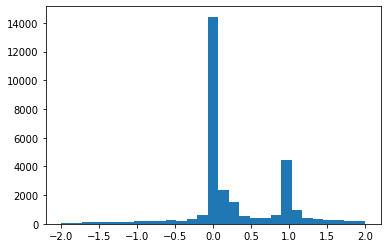

In [32]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for px, py, pz, E

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 5.000e+00,
        7.000e+00, 8.000e+00, 1.700e+01, 2.000e+01, 2.700e+01, 3.000e+01,
        5.100e+01, 5.400e+01, 6.200e+01, 7.400e+01, 1.970e+02, 1.299e+03,
        6.860e+03, 6.880e+02, 4.660e+02, 1.260e+02, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.11794872,  0.12820513,  0.13846154,  0.14871795,
  

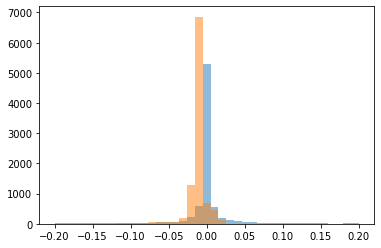

In [33]:
# px
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

In [34]:
print(mse(px,px_pred))

tf.Tensor(0.98666984, shape=(), dtype=float32)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.000e+00,
        5.700e+01, 1.110e+02, 8.700e+01, 1.260e+02, 1.450e+02, 2.000e+02,
        5.530e+02, 7.016e+03, 8.940e+02, 4.580e+02, 2.770e+02, 4.600e+01,
        1.400e+01, 4.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.11794872,  0.12820513,  0.13846154,  0.14871795,
  

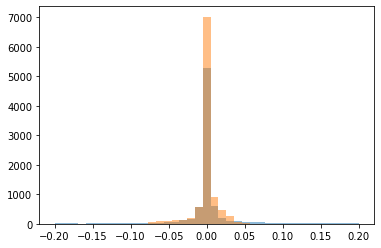

In [35]:
# py
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

In [36]:
print(mse(py,py_pred))

tf.Tensor(1.0404558, shape=(), dtype=float32)


(array([  20.,   24.,   24.,   17.,   27.,   33.,   42.,   39.,   39.,
          59.,   56.,   51.,   72.,   88.,  121.,  139.,  249.,  373.,
         830., 3094.,  804.,  536.,  242.,  158.,  143.,   94.,   72.,
          72.,   60.,   52.,   40.,   38.,   33.,   25.,   28.,   32.,
          24.,   24.,   35.]),
 array([-0.5       , -0.47435897, -0.44871795, -0.42307692, -0.3974359 ,
        -0.37179487, -0.34615385, -0.32051282, -0.29487179, -0.26923077,
        -0.24358974, -0.21794872, -0.19230769, -0.16666667, -0.14102564,
        -0.11538462, -0.08974359, -0.06410256, -0.03846154, -0.01282051,
         0.01282051,  0.03846154,  0.06410256,  0.08974359,  0.11538462,
         0.14102564,  0.16666667,  0.19230769,  0.21794872,  0.24358974,
         0.26923077,  0.29487179,  0.32051282,  0.34615385,  0.37179487,
         0.3974359 ,  0.42307692,  0.44871795,  0.47435897,  0.5       ]),
 <a list of 39 Patch objects>)

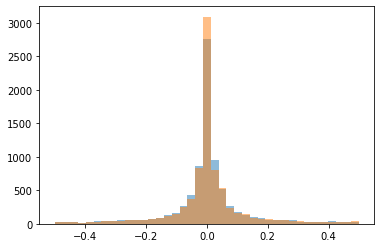

In [37]:
# pz
bins = np.linspace(-0.5, 0.5, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

In [38]:
print(mse(pz,pz_pred))

tf.Tensor(0.00037645505, shape=(), dtype=float32)


(array([   0.,    0., 4201., 1156.,  550.,  347.,  239.,  172.,  130.,
         106.,   97.,   77.,   88.,   54.,   49.,   56.,   37.,   36.,
          48.,   34.,   34.,   41.,   34.,   28.,   17.,   24.,   31.,
          20.,   25.,   21.,   20.,   20.,   16.,   18.,   16.,   21.,
          27.,   21.,   15.]),
 array([-0.6       , -0.57692308, -0.55384615, -0.53076923, -0.50769231,
        -0.48461538, -0.46153846, -0.43846154, -0.41538462, -0.39230769,
        -0.36923077, -0.34615385, -0.32307692, -0.3       , -0.27692308,
        -0.25384615, -0.23076923, -0.20769231, -0.18461538, -0.16153846,
        -0.13846154, -0.11538462, -0.09230769, -0.06923077, -0.04615385,
        -0.02307692,  0.        ,  0.02307692,  0.04615385,  0.06923077,
         0.09230769,  0.11538462,  0.13846154,  0.16153846,  0.18461538,
         0.20769231,  0.23076923,  0.25384615,  0.27692308,  0.3       ]),
 <a list of 39 Patch objects>)

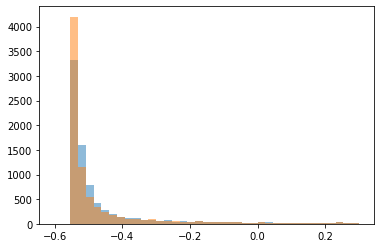

In [39]:
# E
bins = np.linspace(-0.6,0.3, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [40]:
print(mse(e,e_pred))

tf.Tensor(0.00033306712, shape=(), dtype=float32)


In [41]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [42]:
bins = np.linspace(-2, 2, 30)

(array([  31.,   29.,   34.,   38.,   39.,   49.,   36.,   46.,   45.,
          38.,   57.,   40.,   49.,   43.,   49.,   70.,   73.,   83.,
          87.,  115.,  195., 2129.,  329.,  140.,  120.,   89.,   70.,
          57.,   59.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

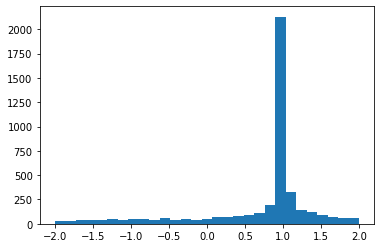

In [43]:
plt.hist(d_px, bins=bins)

(array([  35.,   39.,   44.,   60.,   56.,   51.,   67.,   77.,   71.,
          69.,   97.,   78.,  102.,   88.,  122.,  127.,  140.,  173.,
         166.,  228.,  346., 2312.,  600.,  246.,  172.,  160.,  146.,
         144.,  138.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

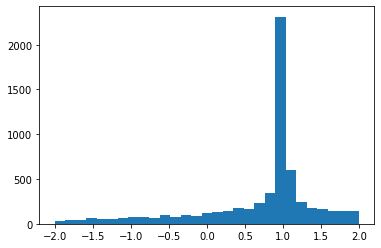

In [44]:
plt.hist(d_py, bins=bins)

(array([  13.,   14.,   13.,   12.,   25.,   32.,   34.,   44.,   55.,
          65.,   94.,  106.,  174.,  282., 4692., 2016., 1313.,  261.,
         171.,   74.,   50.,   28.,   20.,   20.,   23.,   14.,   23.,
           6.,   12.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

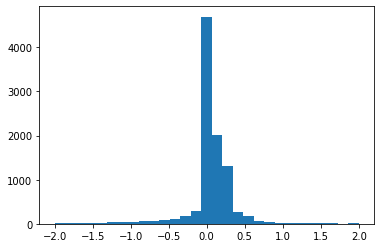

In [45]:
plt.hist(d_pz, bins=bins)

(array([1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 6.000e+00, 5.000e+00, 4.000e+00,
        2.300e+01, 1.660e+02, 9.564e+03, 1.410e+02, 2.400e+01, 1.400e+01,
        1.000e+01, 5.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

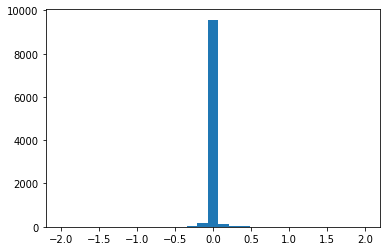

In [46]:
plt.hist(d_e, bins=bins)

# Anomaly Detection

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
# m_12 = sqrt ( (E_1 + E_2)^2 - (p_x1 + p_x2)^2 - (p_y1 + p_y2)^2 - (p_z1 + p_z2)^2 )
def invariant_mass(jet1, jet2):
    return math.sqrt((jet1.e + jet2.e)**2 - (jet1.px + jet2.px)**2 - (jet1.py + jet2.py)**2 - (jet1.pz + jet2.pz)**2)

In [49]:
all_data = np.concatenate((x_train, x_val, x_test))
all_pred = vae.predict(all_data)

In [50]:
# get the iqr weighted mse of all predictions
errors = (iqr_prop[0] * np.square(all_data[:,0] - all_pred[:,0]) + iqr_prop[1] * np.square(all_data[:,1] - all_pred[:,1]) + iqr_prop[2] * np.square(all_data[:,2] - all_pred[:,2]) + iqr_prop[3] * np.square(all_data[:,3] - all_pred[:,3]))

In [51]:
# all the inputs that had high mse
data_df = loaded_data.copy()
data_df.columns = ['px','py','pz','e','pt','eta','phi','mass','event']
data_df["mse"] = errors

In [52]:
mass_mu = data_df.mass.mean()
mass_sd = data_df.mass.std()

In [53]:
cut = 0.95
data_df["outlier"] = 0
# define the outliers by a cut on mse error
mse_thresh = np.quantile(errors, cut)
data_df.loc[data_df["mse"] > mse_thresh, "outlier"] = 1
outliers = data_df.loc[data_df.outlier == 1]

In [54]:
mass = []
for event, group in outliers.groupby(['event']):
    pseudojets_input = np.zeros(len(group), dtype=DTYPE_PTEPM)
    for i in range(len(group.pt.array)):
        pseudojets_input[i]['pT'] = group.pt.array[i]
        pseudojets_input[i]['eta'] = group.eta.array[i]
        pseudojets_input[i]['phi'] = group.phi.array[i]
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    if(len(jets) >= 2):
        mass.append(invariant_mass(jets[0],jets[1]))

In [55]:
path = '/anomalyvol/data/jet_ver/bb1_jet_mass.h5'
mgen = generator(path, chunk_size, total_size)
all_mass = next(mgen)

for i in range(total_size // chunk_size - 1):
    all_mass.append(next(mgen))

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-05, 2.7000e-04,
        2.3500e-03, 1.1130e-02, 2.8070e-02, 4.8320e-02, 7.7080e-02,
        1.1451e-01, 1.1770e-01, 1.0822e-01, 9.1040e-02, 7.7660e-02,
        6.3880e-02, 5.2090e-02, 4.2450e-02, 3.4770e-02, 2.7020e-02,
        2.0710e-02, 1.6780e-02, 1.3540e-02, 1.0930e-02, 8.4800e-03,
        7.2500e-03, 5.7800e-03, 4.3800e-03, 3.5100e-03, 2.7600e-03,
        2.1100e-03, 1.6000e-03, 1.3400e-03, 1.0200e-03, 7.4000e-04,
        5.9000e-04, 5.9000e-04, 2.4000e-04, 2.8000e-04, 2.5000e-04,
        9.0000e-05, 1.5000e-04, 7.0000e-05, 4.0000e-05, 7.0000e-05]),
 array([   0.,  160.,  320.,  480.,  640.,  800.,  960., 1120., 1280.,
        1440., 1600., 1760., 1920., 2080., 2240., 2400., 2560., 2720.,
        2880., 3040., 3200., 3360., 3520., 3680., 3840., 4000., 4160.,
        4320., 4480., 4640., 4800., 4960., 5120., 5280., 5440., 5600.,
        5760., 5920., 6080., 6240.

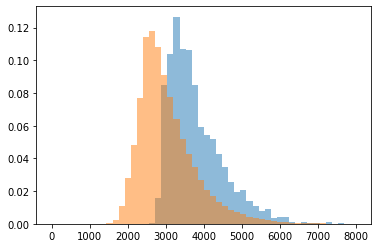

In [72]:
weights = np.ones_like(mass) / len(mass)
plt.hist(mass, bins=np.linspace(0,8000, 51), alpha = 0.5, weights=weights)
weights = np.ones_like(all_mass) / len(all_mass)
plt.hist(all_mass.mass, bins=np.linspace(0,8000, 51), alpha = 0.5, weights=weights)